# Pairs-Trading (Negative Correlation) Strategy Analysis

<!-- Pair Trading Mean Reversion strategy is a market-neutral trading strategy that involves simultaneously buying and selling two correlated financial instruments, such as stocks, ETFs, or currencies, to profit from the relative price movement between them. Here's how it works:

- **Identifying a Pair**: Select two assets that historically show a strong correlation or co-movement. The idea is that the prices of these assets tend to move together over time.
- **Determining the Spread**: Calculate the spread between the prices of the two assets. The spread is typically the difference in their prices or the difference in their log prices.
- **Mean Reversion Hypothesis**: The strategy is based on the assumption that the spread between the two assets will revert to its historical mean or average level over time. When the spread deviates significantly from this mean, it presents a trading opportunity.
- **Trade Execution**:
    - ***Long-Short Position***: When the spread widens beyond a certain threshold, the trader sells the overpriced asset (short position) and buys the underpriced asset (long position). The expectation is that the spread will narrow, and the prices will converge.
    - ***Closing the Position***: Once the spread reverts to the mean, the positions are closed. The profit is realized from the convergence of the spread. -->

In this notebook, the pair trading mean reversion strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

## Credits

The original notebook is from the [quant_research](https://github.com/adamd1985/quant_research) repository by [adamd1985](https://github.com/adamd1985). I want to extend my sincere gratitude to this user for creating this valuable resource. The original work provided the core portion of what I built upon. I have made modifications on the data handling and visual presentation.


## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'venv' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [3]:
pip install -r requirements.txt

You should consider upgrading via the '/Users/gordon.oh/Desktop/quant_research/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. If no pairs are selected, all available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [2]:
##### INPUTS #####
cex = 'binance'
interval = '1h'
nan_remove_threshold = 0.1

# Select only the pairs below to analyse. All pairs will be selected if the list is empty.
selected_pairs = []

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100
##################

In [3]:
print("\nMode: Pairs-Trading (Mean Reversion) Strategy")
print("CEX: {}".format(cex.capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(selected_pairs))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))

merged_df = process_data(cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs)

print("\n")


Mode: Pairs-Trading (Mean Reversion) Strategy
CEX: Binance
Interval: 1h
NaN Remove Threshold: 0.1
Selected pairs to analyse: []
Top N Volume Pairs: 100

Columns that contains NaN values:
        Pair  NaN Count     Remark
1    ZROUSDT        157  To Remove
2  LISTAUSDT        155  To Remove
0    MEWUSDT         85  To Remove
3     ZKUSDT         82  To Remove

Removed 4 pairs as they contain too many NaN values.

Filtered top 100 mean volume pairs.
Successfully loaded candlestick dataframe for all available pairs.

Earliest time series start date: 2024-06-14
Latest time series end date: 2024-07-14




## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [4]:
##### INPUTS #####
start_date = '2024-06-01'
end_date = '2024-07-13'
##################

In [5]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (696, 1)
ETHUSDT's Data Shape: (696, 1)




## Correlation

Correlation quantifies the relationship between two variables using the Pearson correlation coefficient (r). It ranges from -1 to 1, where:
$$ r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}} $$
1. **$r$:** is the Pearson correlation coefficient. 1 means they move perfectly together, -1 is the opposite.
2. **$X_i \text{ and } Y_i$:** are data points of the two variables.
3. **$\bar{X} \text{ and } \bar{Y}$:** are the means of the respective variables.


In [6]:
def find_uncorrelated_pairs(pairs_ts_map, CORRCOEF_VALUE_THRESHOLD):
    """
    Find cointegrated pairs of cryptocurrencies based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - pairs_ts_map (dict): A dictionary where keys are cryptocurrency tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between cryptocurrency pairs.
    - pairs (list): A list of tuples representing cointegrated cryptocurrency pairs and their p-values.
    """
    tickers = list(pairs_ts_map.keys())
    n = len(tickers)

    # Extract 'Close' prices into a matrix (each column is a time series)
    close_data = np.column_stack(
        [pairs_ts_map[ticker]['Close'].values for ticker in tickers])
    correlation_matrix = np.ones((n, n))

    # Calculate correlation for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = np.corrcoef(close_data[:, i], close_data[:, j])[0, 1]
        correlation_matrix[i, j] = result
        
    pairs = [(tickers[i], tickers[j], correlation_matrix[i, j])
             for i, j in zip(*np.where(correlation_matrix < CORRCOEF_VALUE_THRESHOLD))]

    return correlation_matrix, pairs

CORRCOEF_VALUE_THRESHOLD=0

# This section can take a while
corrcoef_values, pairs = find_uncorrelated_pairs(data_sanitized, CORRCOEF_VALUE_THRESHOLD)


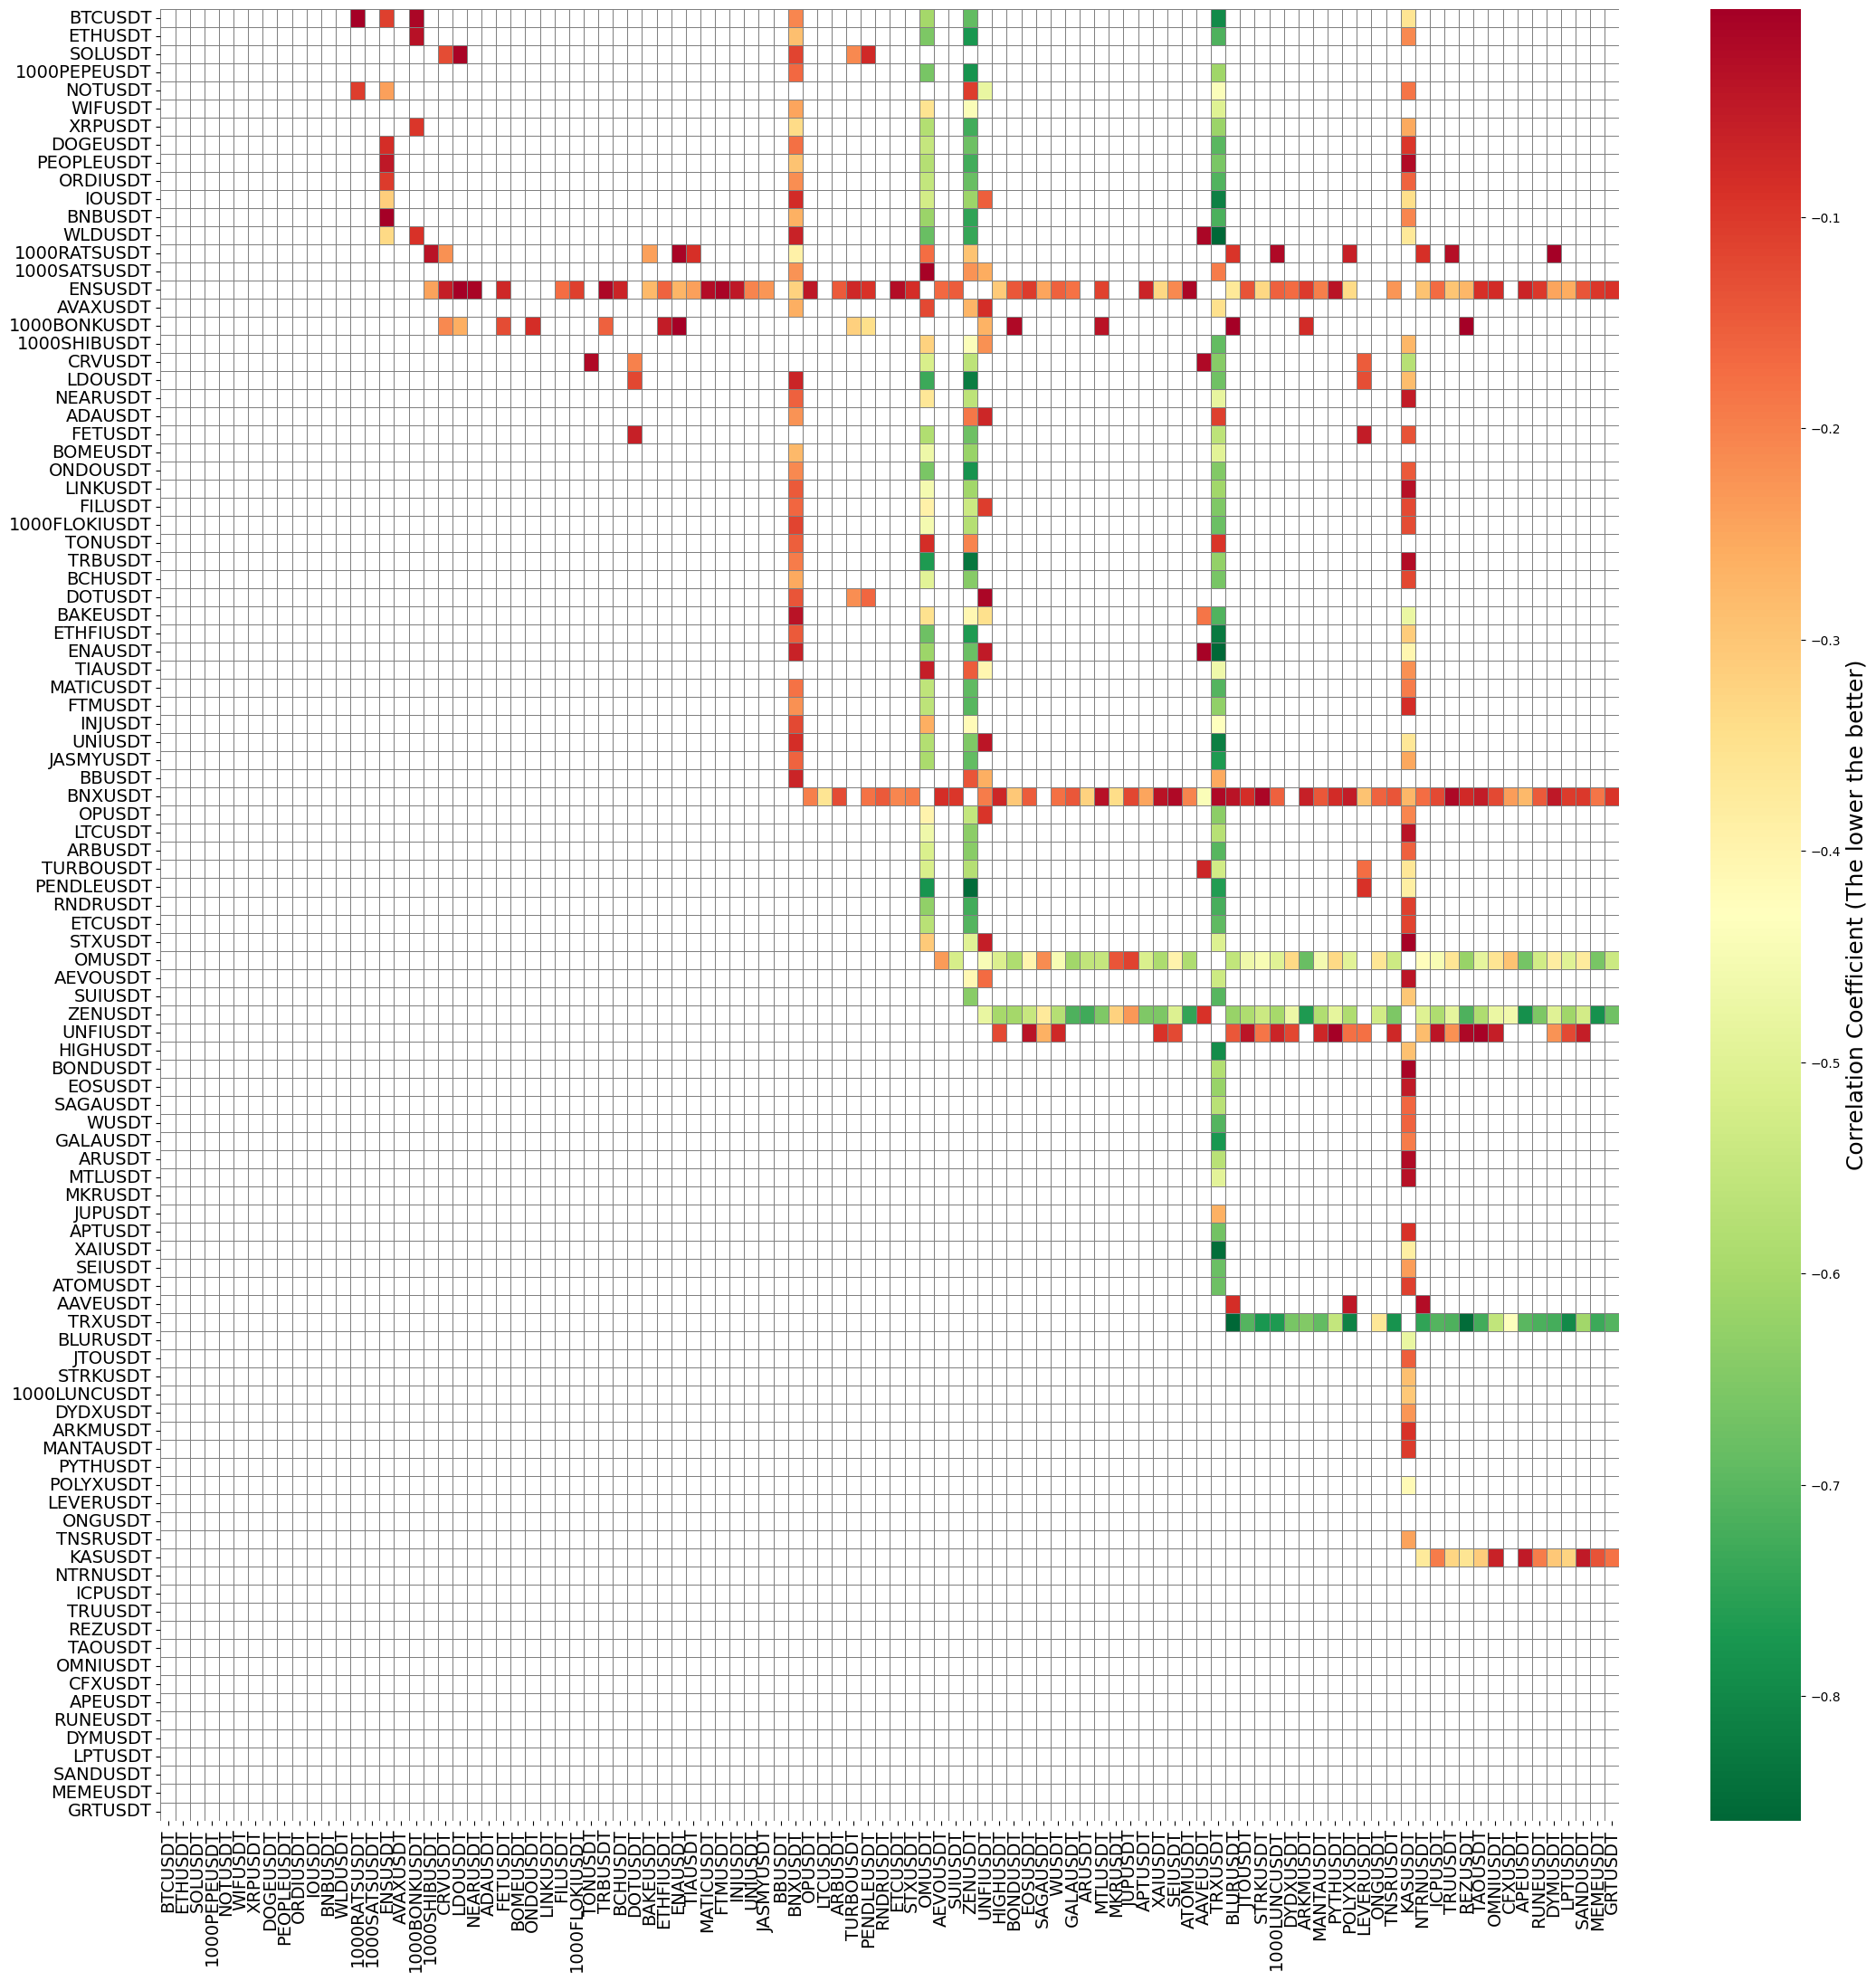

In [7]:
print("\n")

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(corrcoef_values, xticklabels=data_sanitized.keys(),
                      yticklabels=data_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(corrcoef_values > (CORRCOEF_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Correlation Coefficient (The lower the better)', size=18)

plt.show()

print("\n")

In [8]:
##### INPUTS #####
ticker_pairs = [("TRXUSDT", "WLDUSDT"), ("BTCUSDT", "TRXUSDT"), ("ENAUSDT", "TRXUSDT")]
##################

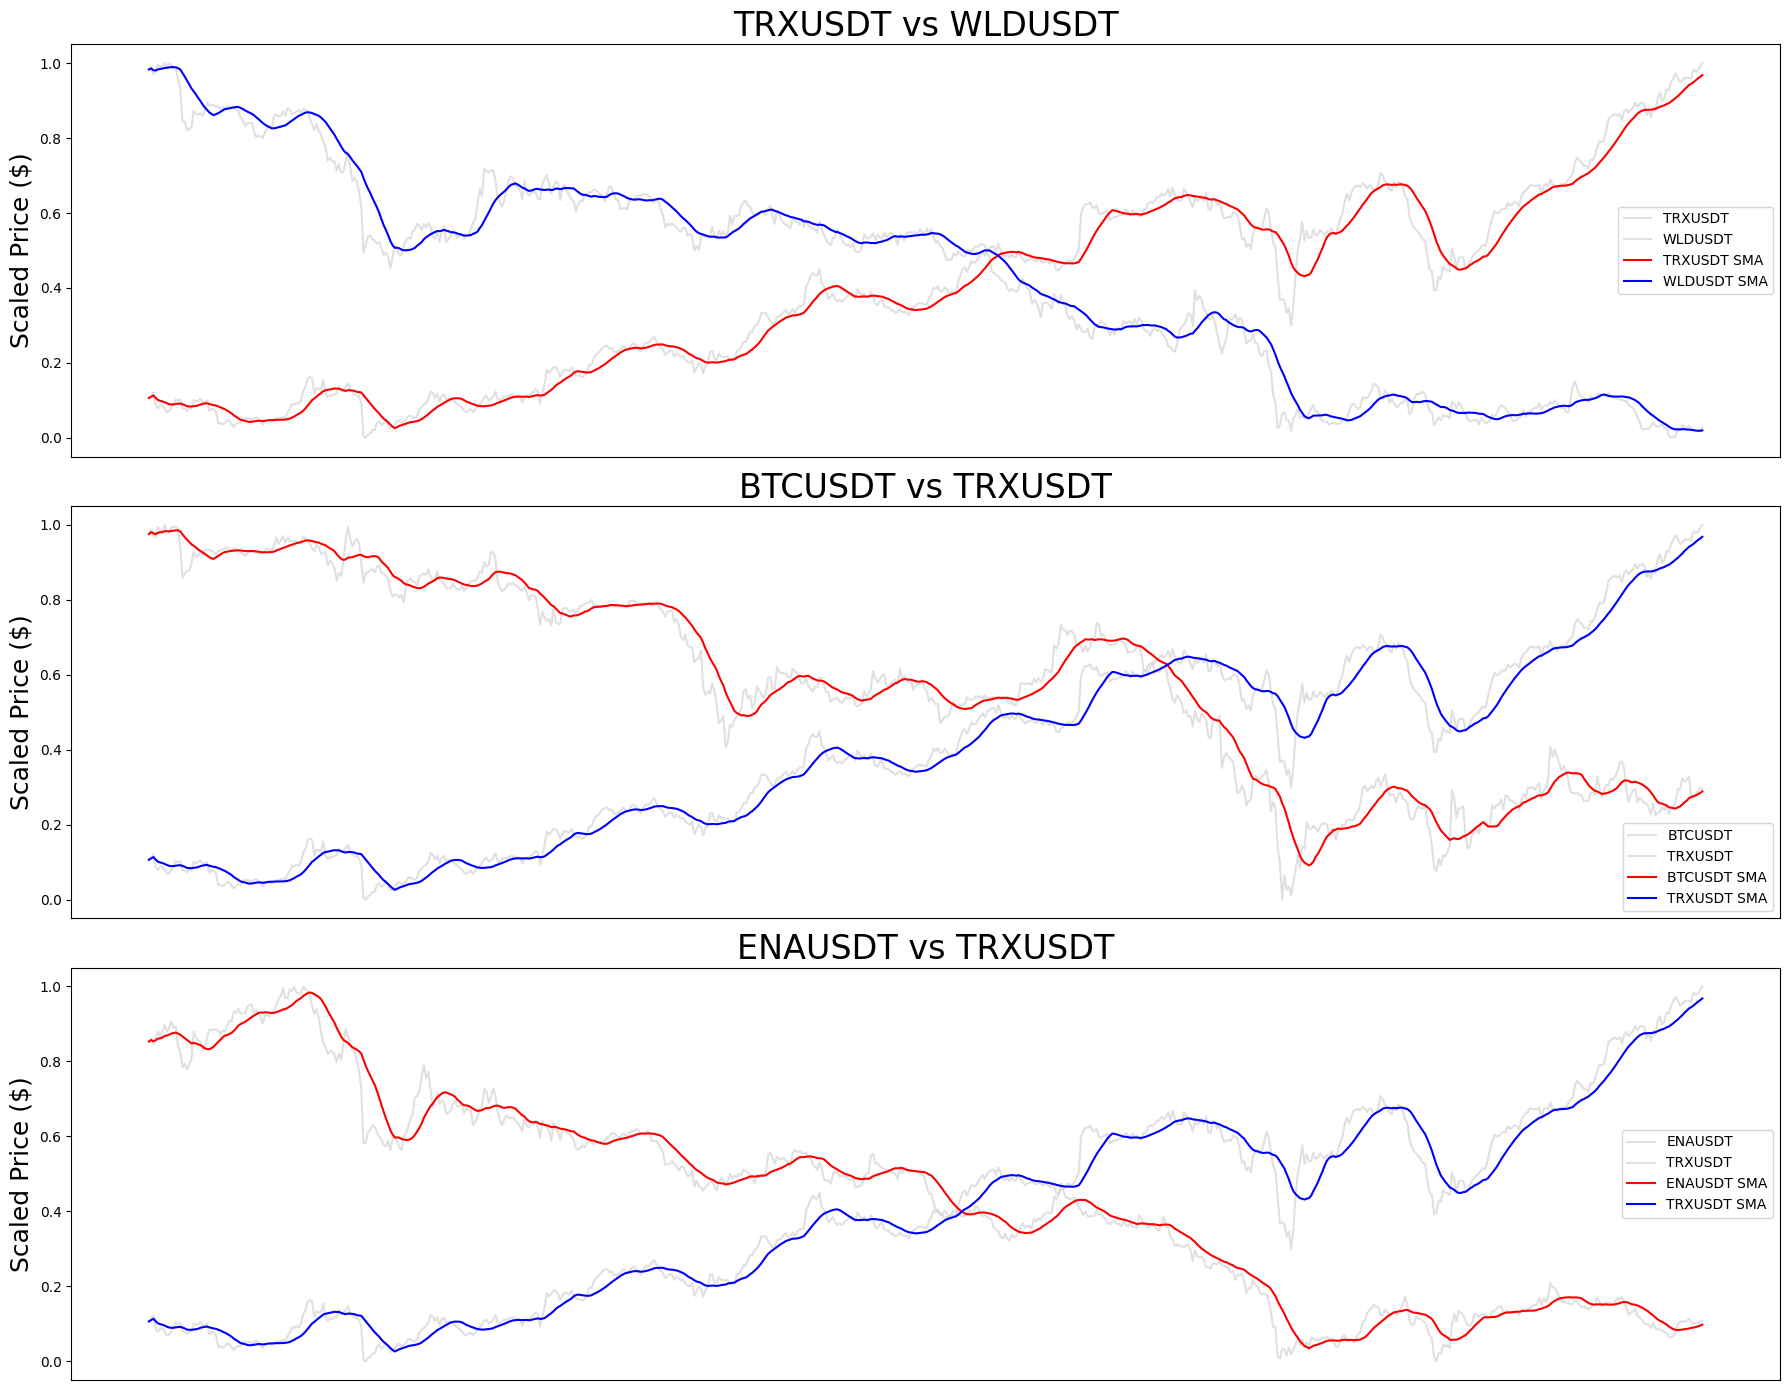

In [9]:
print("\n")

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
if len(ticker_pairs) == 1:
    axs = [axs]
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):

    if ticker1 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker1))
        if ticker2 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker2))
        continue
        
    if ticker2 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker2))
        if ticker1 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker1))
        continue
    
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        data_sanitized[ticker1]['Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        data_sanitized[ticker2]['Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('Scaled Price ($)', fontsize=18)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=24)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

print("\n")